In [4]:
import triton
import triton.language as tl
import torch

### Compute Kernel

In [ ]:
@triton.jit
def softmax_kernel(a_ptr,
                   b_ptr,
                   n_rows,
                   n_cols,
                   a_row_stride,
                   b_row_stride,
                   BLOCK_SIZE: tl.constexpr, #BLOCK_SIZE is the next pwr of 2 larger than n_cols
                   num_stages: tl.constexpr,
                   ):
    row_start  = tl.program_id(0)
    row_stride = tl.num_programs(0)

    for row in tl.range(row_start, n_rows, row_stride, num_stages=num_stages):
        offsets   = tl.arange(0, BLOCK_SIZE)
        start_ptr = a_ptr + row * a_row_stride
        ptrs_mask = offsets < n_cols
        curr_row  = tl.load((start_ptr + offsets), mask=ptrs_mask, other=-float("inf"))

        row_minus_max = curr_row - tl.max(curr_row, axis=0)
        row_exp       = tl.exp(row_minus_max)
        row_norm      = row_exp / tl.sum(row_exp, axis=0)

        b_offsets = tl.arange(0, BLOCK_SIZE)
        b_start   = b_ptr + row * b_row_stride
        b_mask    = b_offsets < n_cols
        tl.store((b_start + b_offsets), row_norm, mask=b_mask)

### Kernel Caller

In [ ]:
DEVICE     = triton.runtime.driver.active.get_active_torch_device()
properties = triton.runtime.driver.active.utils.get_device_properties(DEVICE.index)
NUM_SM     = properties["multiprocessor_count"]
NUM_REGS   = properties["max_num_regs"]
SIZE_SMEM  = properties["max_shared_mem"]
WARP_SIZE  = properties["warpSize"]
target     = triton.runtime.driver.active.get_current_target()
kernels    = {}

# Print all of the above variables
print(f"Device: {DEVICE}")
print(f"Properties: {properties}")
print(f"Number of SMs: {NUM_SM}")
print(f"Number of registers: {NUM_REGS}")
print(f"Size of shared memory: {SIZE_SMEM}")
print(f"Warp size: {WARP_SIZE}")
print(f"Target: {target}")

def softmax(a: torch.Tensor) -> torch.Tensor:
    b = torch.empty_like(a)
    
    # To be autotuned in coming tutorials
    BLOCK_SIZE = triton.next_power_of_2(b.shape[1])
    num_stages = 4 if SIZE_SMEM > 200000 else 2
    num_warps  = 8

    kernel = softmax_kernel.warmup(a, b,
                                   a.shape[0], a.shape[1],
                                   a.stride(0), b.stride(0),
                                   BLOCK_SIZE=BLOCK_SIZE,
                                   num_stages=num_stages,
                                   num_warps =num_warps,
                                   grid=(1, ),
                                   )
    kernel._init_handles()
    n_regs = kernel.n_regs             # num of regs each thread will use
    size_smem = kernel.metadata.shared # amount of smem each thread block will use
    
    reg_occupancy  = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
    smem_occupancy = SIZE_SMEM // size_smem
    occupancy      = min(reg_occupancy, smem_occupancy)

    num_programs = min(occupancy * NUM_SM, a.shape[0])
    kernel[(num_programs, 1, 1)](a, b,
                                 a.shape[0], a.shape[1],
                                 a.stride(0), b.stride(0),
                                 BLOCK_SIZE,
                                 num_stages
                                 )
    return b

Device: cuda:0
Properties: {'max_shared_mem': 101376, 'max_num_regs': 65536, 'multiprocessor_count': 82, 'warpSize': 32, 'sm_clock_rate': 1695000, 'mem_clock_rate': 9751000, 'mem_bus_width': 384}
Number of SMs: 82
Number of registers: 65536
Size of shared memory: 101376
Warp size: 32
Target: GPUTarget(backend='cuda', arch=86, warp_size=32)


### Naive Softmax

In [57]:
def naive_softmax(x: torch.Tensor) -> torch.Tensor:
    x_max = x.max(dim=1)[0]
    z = x - x_max[:, None]
    numerator = torch.exp(z)
    denominator = numerator.sum(dim=1)
    ret = numerator / denominator[:, None]
    return ret

### Unit Test

In [58]:
a = torch.randn((8192, 768), device=DEVICE)

b1 = torch.softmax(a, axis=1)
b2 = softmax(a)

print(b1)
print("----------------------------------------------")
print(b2)

triton.testing.assert_close(b1, b2)

tensor([[0.0002, 0.0004, 0.0019,  ..., 0.0017, 0.0005, 0.0004],
        [0.0005, 0.0002, 0.0024,  ..., 0.0006, 0.0011, 0.0009],
        [0.0005, 0.0002, 0.0021,  ..., 0.0006, 0.0003, 0.0005],
        ...,
        [0.0012, 0.0003, 0.0008,  ..., 0.0013, 0.0002, 0.0009],
        [0.0075, 0.0005, 0.0203,  ..., 0.0055, 0.0013, 0.0030],
        [0.0006, 0.0004, 0.0003,  ..., 0.0006, 0.0005, 0.0008]],
       device='cuda:0')
----------------------------------------------
tensor([[0.0002, 0.0004, 0.0019,  ..., 0.0017, 0.0005, 0.0004],
        [0.0005, 0.0002, 0.0024,  ..., 0.0006, 0.0011, 0.0009],
        [0.0005, 0.0002, 0.0021,  ..., 0.0006, 0.0003, 0.0005],
        ...,
        [0.0012, 0.0003, 0.0008,  ..., 0.0013, 0.0002, 0.0009],
        [0.0075, 0.0005, 0.0203,  ..., 0.0055, 0.0013, 0.0030],
        [0.0006, 0.0004, 0.0003,  ..., 0.0006, 0.0005, 0.0008]],
       device='cuda:0')


### Benchmark

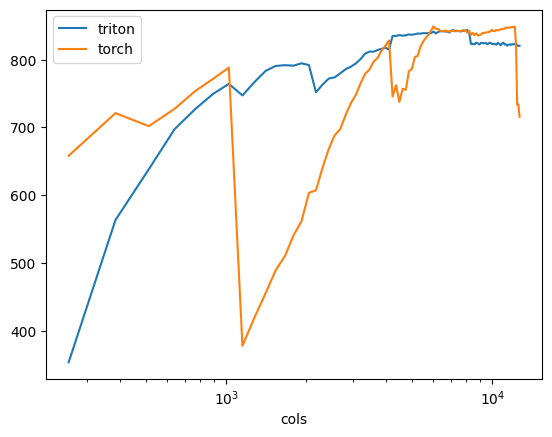

Triton vs. Torch:
       cols      triton       torch
0     256.0  354.055389  658.311218
1     384.0  563.771530  721.198560
2     512.0  638.346834  701.966511
3     640.0  697.423494  727.424625
4     768.0  727.668550  754.109476
5     896.0  749.822214  771.976180
6    1024.0  764.247381  788.284478
7    1152.0  747.248815  378.393843
8    1280.0  767.184553  420.512778
9    1408.0  783.434100  456.038240
10   1536.0  790.676921  489.785760
11   1664.0  791.791811  510.611720
12   1792.0  791.090103  541.320339
13   1920.0  794.583805  561.829522
14   2048.0  791.974704  603.753689
15   2176.0  751.872624  607.430008
16   2304.0  763.160145  640.620278
17   2432.0  772.110811  668.623672
18   2560.0  773.918340  688.589495
19   2688.0  779.910757  697.828392
20   2816.0  785.915912  718.893025
21   2944.0  789.680374  735.914008
22   3072.0  794.281009  747.938953
23   3200.0  800.764377  764.670864
24   3328.0  808.743799  779.065040
25   3456.0  811.754837  785.197516
26   3584.

In [59]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names    = ["cols"],
        x_vals     = [128 * i for i in range(2, 100)],
        line_arg   = "provider",
        line_vals  = ["triton", "torch"],
        line_names = ["triton", "torch"],
        plot_name  = "Triton vs. Torch",
        args       = {},
        x_log      = True
    )
)
def benchmark(cols, provider):
    a = torch.randn((4096, cols), device=DEVICE)
    if provider == "torch":
        ms = triton.testing.do_bench(lambda: torch.softmax(a, axis=-1))
    else:
        ms = triton.testing.do_bench(lambda: softmax(a))
    return (a.numel() * a.element_size() * 2 * 1e-9) / (ms * 1e-3)

benchmark.run(show_plots=True, print_data=True)
    